In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/bsuhome/yavarpourmohamad/miniforge3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

newCmapp = {
    'Power': '#a6cee3',
    'Equipment': '#1f78b4',
    'Recreation': '#b2df8a',
    'Debris': '#33a02c',
    'Arson': '#fb9a99',
    'Misuse by minor': '#e31a1c',
    'Natural': '#fdbf6f',
    'Firearms': '#ff7f00',
    'Fireworks': '#cab2d6',
    'Railroad': '#ffff99',
    'Smoking': '#b15928'
}
causes = ['Natural', 'Debris', 'Fireworks', 'Arson', 'Recreation', 'Smoking',
          'Equipment', 'Power', 'Misuse by minor', 'Firearms', 'Railroad']
states = gpd.read_file(filename = '/bsuhome/yavarpourmohamad/scratch/FPA_FOD_Paper/Grid_variable_map/States/cb_2018_us_state_500k.shp')
states = states[['STUSPS', 'NAME', 'geometry']]
states = states.to_crs('EPSG:4326')
sts = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
sts.sort()
states = states.loc[states['STUSPS'].isin(sts)]
csv_list = glob.glob(pathname='/bsuhome/yavarpourmohamad/scratch/Dissertation/Cause_specific/Time_series_grid/yearly/ts_data_cause20*.csv')
csv_list.sort()

In [3]:
nwcg = pd.read_csv(filepath_or_buffer = '/bsuhome/yavarpourmohamad/scratch/Dissertation/Code/Karen_email/NWCG_UnitIdActive_20200123.csv', sep = ',')
cols_FPA = ['STATE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'NWCG_GENERAL_CAUSE', 'LONGITUDE', 'LATITUDE']
FPA_FOD = pd.read_csv(filepath_or_buffer = '/bsuhome/yavarpourmohamad/scratch/Dissertation/Data/FPA_FOD/FPA_FOD_Plus.csv',
                      sep = ',', low_memory = False)
sts = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
sts.sort()
FPA_FOD = FPA_FOD.loc[FPA_FOD['STATE'].isin(sts)]
FPA_FOD = FPA_FOD.loc[FPA_FOD['LONGITUDE'] < -102.05]
FPA_FOD = pd.merge(left = FPA_FOD,
                   left_on = 'NWCG_REPORTING_UNIT_ID',
                   right = nwcg[['UnitId', 'UnitType']],
                   right_on = 'UnitId',
                   how = 'left')
FPA_FOD = FPA_FOD[~((FPA_FOD['FIRE_SIZE'] <= 0.1) & (FPA_FOD['Land_Cover'].isin([22, 23, 24])) & (FPA_FOD['UnitType'].isin(['US County/Local'])))]
FPA_FOD = FPA_FOD[cols_FPA]
cause_dic =  {'Debris and open burning': 'Debris',
              'Arson/incendiarism': 'Arson',
              'Recreation and ceremony': 'Recreation',
              'Missing data/not specified/undetermined': 'Missing',
              'Equipment and vehicle use': 'Equipment',
              'Power generation/transmission/distribution': 'Power',
              'Misuse of fire by a minor': 'Misuse by minor',
              'Firearms and explosives use': 'Firearms',
              'Railroad operations and maintenance': 'Railroad'}
FPA_FOD['NWCG_GENERAL_CAUSE'] = FPA_FOD['NWCG_GENERAL_CAUSE'].replace(cause_dic)              
FPA_FOD = FPA_FOD[~FPA_FOD['NWCG_GENERAL_CAUSE'].isin(['Other causes', 'Missing'])]
FPA_FOD = FPA_FOD.loc[FPA_FOD['FIRE_YEAR'] > 2015, ]
FPA_total = FPA_FOD.groupby(by=['STATE', 'NWCG_GENERAL_CAUSE']).size().reset_index(name='Counts')
FPA_total['Counts'] = FPA_total['Counts']/5
FPA_total['source'] = 'Ignition load'

In [6]:
first = True
for csv in tqdm(csv_list[:]):
    temp = pd.read_csv(filepath_or_buffer=csv, sep=',', low_memory=False)
    temp = temp.groupby('STATE')[causes].sum()
    temp = temp.reset_index()
    year = ''.join(c for c in csv if c.isdigit())
    if first:
        total = temp.copy(deep=True)
        first = False
    else:
        total[causes] = total[causes] + temp[causes]
total[causes] = total[causes]/5
total= total.melt(id_vars='STATE',
                  value_vars=causes,
                  var_name='NWCG_GENERAL_CAUSE',
                  value_name='Counts')
total['source'] = 'Pixel day'

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [06:45<00:00, 81.09s/it]


In [7]:
plt_df = pd.concat(objs=[FPA_total, total])
plt_df = plt_df.pivot_table(index=["STATE", "source"],
                            columns="NWCG_GENERAL_CAUSE",
                            values="Counts",
                            fill_value=0).reset_index()
plt_df.to_csv(path_or_buf='/bsuhome/yavarpourmohamad/scratch/Dissertation/Cause_specific/Mapping/ML_on_TS/Fig_1.csv',
              sep=',', index=False)

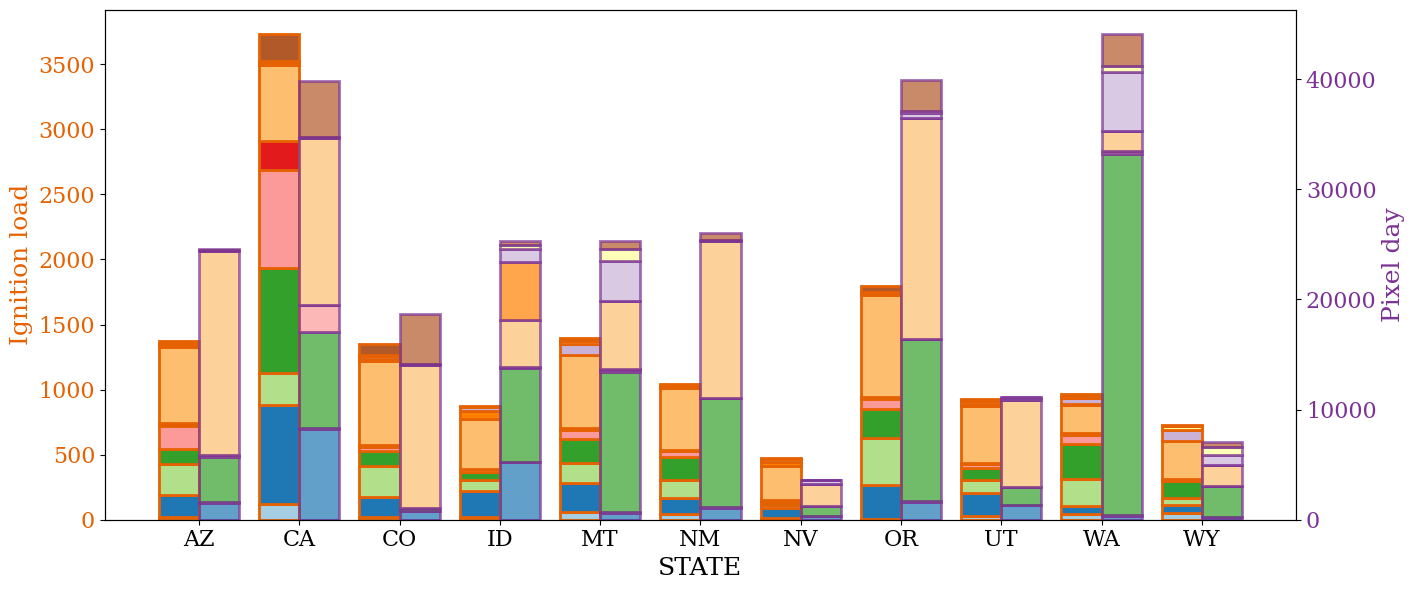

In [8]:
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
cause_cols = list(newCmapp.keys())

data_for_plot = {}
for source in ['Ignition load', 'Pixel day']:
    df_source = plt_df[plt_df['source'] == source].set_index('STATE')
    df_plot = df_source[cause_cols]
    df_plot_T = df_plot.T
    data_for_plot[source] = df_plot_T

df_ignite = data_for_plot['Ignition load']
df_pixel = data_for_plot['Pixel day']

states = df_ignite.columns
causes = df_ignite.index
fig, ax1 = plt.subplots(figsize=(15, 6))
bar_width = 0.4
x_pos = np.arange(len(states))

# -----------------
# LEFT Y-AXIS (ax1): Ignition Load
# -----------------
ax1.set_ylabel('Ignition load', color='#e66101', fontsize=LABEL_FONTSIZE)
ax1.tick_params(axis='y', labelcolor='#e66101', labelsize=TICK_FONTSIZE)
bottom_ignite = np.zeros(len(states))

for cause in causes:
    ax1.bar(
        x_pos - bar_width/2,           # Shift left by half bar_width
        df_ignite.loc[cause],          # Cause values
        bar_width,                     # Bar width
        label=cause,                   # Label for legend
        bottom=bottom_ignite,          # Start position for stacking
        color=newCmapp.get(cause),     # Custom color
        linewidth=2,
        edgecolor="#e66101"
    )
    bottom_ignite += df_ignite.loc[cause].values

# -----------------
# RIGHT Y-AXIS (ax2): Pixel Day
# -----------------
# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Pixel day', color='#7b3294', fontsize=LABEL_FONTSIZE)
ax2.tick_params(axis='y', labelcolor='#7b3294', labelsize=TICK_FONTSIZE)
bottom_pixel = np.zeros(len(states))

for cause in causes:
    ax2.bar(
        x_pos + bar_width/2,           # Shift right by half bar_width
        df_pixel.loc[cause],           # Cause values
        bar_width,                     # Bar width
        label=cause,                   # Label for legend (only needed once, but safe here)
        bottom=bottom_pixel,           # Start position for stacking
        color=newCmapp.get(cause),      # Custom color
        alpha=0.7,                     # Use lower opacity for distinction
        linewidth=2,
        edgecolor="#7b3294"
    )
    bottom_pixel += df_pixel.loc[cause].values

ax1.set_xticks(ticks=x_pos)
ax1.set_xticklabels(states, rotation=0, fontsize=TICK_FONTSIZE) # Increased tick size
ax1.set_xlabel('STATE', fontsize=LABEL_FONTSIZE)

plt.tight_layout(rect=[0, 0, 0.95, 1]) 
plt.show()